# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 996us/sample - loss: 226.4831 - y1_output_loss: 103.2391 - y2_output_loss: 121.4616 - y1_output_root_mean_squared_error: 10.2051 - y2_output_root_mean_squared_error: 11.0607 - val_loss: 26.2281 - val_y1_output_loss: 11.0716 - val_y2_output_loss: 16.1872 - val_y1_output_root_mean_squared_error: 3.2467 - val_y2_output_root_mean_squared_error: 3.9607
Epoch 2/500
614/614 [==============================] - 0s 159us/sample - loss: 43.3522 - y1_output_loss: 14.5309 - y2_output_loss: 28.5236 - y1_output_root_mean_squared_error: 3.8234 - y2_output_root_mean_squared_error: 5.3604 - val_loss: 17.6892 - val_y1_output_loss: 7.8256 - val_y2_output_loss: 9.7509 - val_y1_output_root_mean_squared_error: 2.7957 - val_y2_output_root_mean_squared_error: 3.1422
Epoch 3/500
614/614 [==============================] - 0s 149us/sample - loss: 26.2486 - y1_output_loss: 10.1538 - y2_output_loss: 15.9664 - y1_o

614/614 [==============================] - 0s 142us/sample - loss: 9.2333 - y1_output_loss: 3.0288 - y2_output_loss: 6.1301 - y1_output_root_mean_squared_error: 1.7481 - y2_output_root_mean_squared_error: 2.4854 - val_loss: 9.9647 - val_y1_output_loss: 3.6447 - val_y2_output_loss: 6.1526 - val_y1_output_root_mean_squared_error: 1.9241 - val_y2_output_root_mean_squared_error: 2.5025
Epoch 42/500
614/614 [==============================] - 0s 155us/sample - loss: 9.0593 - y1_output_loss: 3.0902 - y2_output_loss: 5.9251 - y1_output_root_mean_squared_error: 1.7632 - y2_output_root_mean_squared_error: 2.4393 - val_loss: 7.0161 - val_y1_output_loss: 2.8990 - val_y2_output_loss: 3.9051 - val_y1_output_root_mean_squared_error: 1.7315 - val_y2_output_root_mean_squared_error: 2.0045
Epoch 43/500
614/614 [==============================] - 0s 149us/sample - loss: 8.1648 - y1_output_loss: 2.8233 - y2_output_loss: 5.2696 - y1_output_root_mean_squared_error: 1.6876 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 144us/sample - loss: 6.7141 - y1_output_loss: 1.7181 - y2_output_loss: 5.0969 - y1_output_root_mean_squared_error: 1.3134 - y2_output_root_mean_squared_error: 2.2336 - val_loss: 20.5254 - val_y1_output_loss: 4.1090 - val_y2_output_loss: 16.1575 - val_y1_output_root_mean_squared_error: 2.0371 - val_y2_output_root_mean_squared_error: 4.0467
Epoch 63/500
614/614 [==============================] - 0s 138us/sample - loss: 5.0646 - y1_output_loss: 1.2605 - y2_output_loss: 3.8319 - y1_output_root_mean_squared_error: 1.1245 - y2_output_root_mean_squared_error: 1.9494 - val_loss: 4.6239 - val_y1_output_loss: 1.2956 - val_y2_output_loss: 3.2189 - val_y1_output_root_mean_squared_error: 1.1549 - val_y2_output_root_mean_squared_error: 1.8138
Epoch 64/500
614/614 [==============================] - 0s 146us/sample - loss: 4.8931 - y1_output_loss: 1.1394 - y2_output_loss: 3.7456 - y1_output_root_mean_squared_error: 1.0611 - y2_output_root_mean

Epoch 83/500
614/614 [==============================] - 0s 145us/sample - loss: 3.5692 - y1_output_loss: 0.7631 - y2_output_loss: 2.7981 - y1_output_root_mean_squared_error: 0.8774 - y2_output_root_mean_squared_error: 1.6731 - val_loss: 3.5707 - val_y1_output_loss: 0.5226 - val_y2_output_loss: 3.0169 - val_y1_output_root_mean_squared_error: 0.7243 - val_y2_output_root_mean_squared_error: 1.7453
Epoch 84/500
614/614 [==============================] - 0s 143us/sample - loss: 4.3568 - y1_output_loss: 0.9009 - y2_output_loss: 3.4742 - y1_output_root_mean_squared_error: 0.9471 - y2_output_root_mean_squared_error: 1.8601 - val_loss: 6.4474 - val_y1_output_loss: 1.8700 - val_y2_output_loss: 4.4684 - val_y1_output_root_mean_squared_error: 1.3812 - val_y2_output_root_mean_squared_error: 2.1307
Epoch 85/500
614/614 [==============================] - 0s 150us/sample - loss: 3.6940 - y1_output_loss: 0.7798 - y2_output_loss: 2.9322 - y1_output_root_mean_squared_error: 0.8798 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 144us/sample - loss: 2.5598 - y1_output_loss: 0.5849 - y2_output_loss: 1.9527 - y1_output_root_mean_squared_error: 0.7682 - y2_output_root_mean_squared_error: 1.4035 - val_loss: 1.9629 - val_y1_output_loss: 0.2848 - val_y2_output_loss: 1.6277 - val_y1_output_root_mean_squared_error: 0.5383 - val_y2_output_root_mean_squared_error: 1.2935
Epoch 105/500
614/614 [==============================] - 0s 139us/sample - loss: 2.2041 - y1_output_loss: 0.4804 - y2_output_loss: 1.7339 - y1_output_root_mean_squared_error: 0.6962 - y2_output_root_mean_squared_error: 1.3113 - val_loss: 6.1767 - val_y1_output_loss: 0.7333 - val_y2_output_loss: 5.2969 - val_y1_output_root_mean_squared_error: 0.8669 - val_y2_output_root_mean_squared_error: 2.3292
Epoch 106/500
614/614 [==============================] - 0s 135us/sample - loss: 2.8405 - y1_output_loss: 0.5743 - y2_output_loss: 2.2413 - y1_output_root_mean_squared_error: 0.7603 - y2_output_root_mea

Epoch 145/500
614/614 [==============================] - 0s 149us/sample - loss: 2.2282 - y1_output_loss: 0.4596 - y2_output_loss: 1.7667 - y1_output_root_mean_squared_error: 0.6757 - y2_output_root_mean_squared_error: 1.3310 - val_loss: 2.0616 - val_y1_output_loss: 0.5001 - val_y2_output_loss: 1.5481 - val_y1_output_root_mean_squared_error: 0.7052 - val_y2_output_root_mean_squared_error: 1.2507
Epoch 146/500
614/614 [==============================] - 0s 147us/sample - loss: 1.8824 - y1_output_loss: 0.3485 - y2_output_loss: 1.5211 - y1_output_root_mean_squared_error: 0.5906 - y2_output_root_mean_squared_error: 1.2384 - val_loss: 1.3624 - val_y1_output_loss: 0.2127 - val_y2_output_loss: 1.1251 - val_y1_output_root_mean_squared_error: 0.4613 - val_y2_output_root_mean_squared_error: 1.0722
Epoch 147/500
614/614 [==============================] - 0s 146us/sample - loss: 1.9333 - y1_output_loss: 0.3991 - y2_output_loss: 1.5239 - y1_output_root_mean_squared_error: 0.6333 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 140us/sample - loss: 2.0725 - y1_output_loss: 0.4431 - y2_output_loss: 1.6139 - y1_output_root_mean_squared_error: 0.6677 - y2_output_root_mean_squared_error: 1.2754 - val_loss: 1.4496 - val_y1_output_loss: 0.3396 - val_y2_output_loss: 1.0897 - val_y1_output_root_mean_squared_error: 0.5846 - val_y2_output_root_mean_squared_error: 1.0525
Epoch 187/500
614/614 [==============================] - 0s 138us/sample - loss: 1.3687 - y1_output_loss: 0.2506 - y2_output_loss: 1.1279 - y1_output_root_mean_squared_error: 0.4979 - y2_output_root_mean_squared_error: 1.0587 - val_loss: 1.5685 - val_y1_output_loss: 0.2567 - val_y2_output_loss: 1.2832 - val_y1_output_root_mean_squared_error: 0.5081 - val_y2_output_root_mean_squared_error: 1.1447
Epoch 188/500
614/614 [==============================] - 0s 143us/sample - loss: 1.4889 - y1_output_loss: 0.2837 - y2_output_loss: 1.1948 - y1_output_root_mean_squared_error: 0.5339 - y2_output_root_mea

Epoch 227/500
614/614 [==============================] - 0s 152us/sample - loss: 1.1026 - y1_output_loss: 0.2266 - y2_output_loss: 0.9163 - y1_output_root_mean_squared_error: 0.4774 - y2_output_root_mean_squared_error: 0.9353 - val_loss: 5.9792 - val_y1_output_loss: 0.4431 - val_y2_output_loss: 5.4568 - val_y1_output_root_mean_squared_error: 0.6698 - val_y2_output_root_mean_squared_error: 2.3517
Epoch 228/500
614/614 [==============================] - 0s 149us/sample - loss: 1.5167 - y1_output_loss: 0.2918 - y2_output_loss: 1.2116 - y1_output_root_mean_squared_error: 0.5426 - y2_output_root_mean_squared_error: 1.1056 - val_loss: 1.0226 - val_y1_output_loss: 0.2363 - val_y2_output_loss: 0.7648 - val_y1_output_root_mean_squared_error: 0.4890 - val_y2_output_root_mean_squared_error: 0.8851
Epoch 229/500
614/614 [==============================] - 0s 148us/sample - loss: 0.9571 - y1_output_loss: 0.2288 - y2_output_loss: 0.7255 - y1_output_root_mean_squared_error: 0.4787 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 150us/sample - loss: 0.9472 - y1_output_loss: 0.2049 - y2_output_loss: 0.7476 - y1_output_root_mean_squared_error: 0.4500 - y2_output_root_mean_squared_error: 0.8630 - val_loss: 2.0561 - val_y1_output_loss: 0.4537 - val_y2_output_loss: 1.5528 - val_y1_output_root_mean_squared_error: 0.6841 - val_y2_output_root_mean_squared_error: 1.2602
Epoch 269/500
614/614 [==============================] - 0s 142us/sample - loss: 1.1610 - y1_output_loss: 0.2736 - y2_output_loss: 0.8810 - y1_output_root_mean_squared_error: 0.5244 - y2_output_root_mean_squared_error: 0.9413 - val_loss: 1.3527 - val_y1_output_loss: 0.3594 - val_y2_output_loss: 0.9818 - val_y1_output_root_mean_squared_error: 0.5994 - val_y2_output_root_mean_squared_error: 0.9967
Epoch 270/500
614/614 [==============================] - 0s 139us/sample - loss: 0.8572 - y1_output_loss: 0.1722 - y2_output_loss: 0.6858 - y1_output_root_mean_squared_error: 0.4133 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 139us/sample - loss: 0.6150 - y1_output_loss: 0.1500 - y2_output_loss: 0.4660 - y1_output_root_mean_squared_error: 0.3833 - y2_output_root_mean_squared_error: 0.6842 - val_loss: 1.2424 - val_y1_output_loss: 0.4223 - val_y2_output_loss: 0.7908 - val_y1_output_root_mean_squared_error: 0.6581 - val_y2_output_root_mean_squared_error: 0.8997
Epoch 310/500
614/614 [==============================] - 0s 152us/sample - loss: 0.7131 - y1_output_loss: 0.1555 - y2_output_loss: 0.5536 - y1_output_root_mean_squared_error: 0.3946 - y2_output_root_mean_squared_error: 0.7466 - val_loss: 0.9462 - val_y1_output_loss: 0.2019 - val_y2_output_loss: 0.7376 - val_y1_output_root_mean_squared_error: 0.4508 - val_y2_output_root_mean_squared_error: 0.8620
Epoch 311/500
614/614 [==============================] - 0s 143us/sample - loss: 0.6000 - y1_output_loss: 0.1398 - y2_output_loss: 0.4608 - y1_output_root_mean_squared_error: 0.3754 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 137us/sample - loss: 0.9179 - y1_output_loss: 0.2041 - y2_output_loss: 0.7095 - y1_output_root_mean_squared_error: 0.4508 - y2_output_root_mean_squared_error: 0.8454 - val_loss: 0.8565 - val_y1_output_loss: 0.2413 - val_y2_output_loss: 0.5944 - val_y1_output_root_mean_squared_error: 0.4963 - val_y2_output_root_mean_squared_error: 0.7811
Epoch 351/500
614/614 [==============================] - 0s 140us/sample - loss: 0.6002 - y1_output_loss: 0.1483 - y2_output_loss: 0.4496 - y1_output_root_mean_squared_error: 0.3851 - y2_output_root_mean_squared_error: 0.6722 - val_loss: 0.8861 - val_y1_output_loss: 0.2068 - val_y2_output_loss: 0.6610 - val_y1_output_root_mean_squared_error: 0.4595 - val_y2_output_root_mean_squared_error: 0.8216
Epoch 352/500
614/614 [==============================] - 0s 151us/sample - loss: 1.2089 - y1_output_loss: 0.2373 - y2_output_loss: 0.9616 - y1_output_root_mean_squared_error: 0.4887 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 141us/sample - loss: 0.5182 - y1_output_loss: 0.1244 - y2_output_loss: 0.3920 - y1_output_root_mean_squared_error: 0.3538 - y2_output_root_mean_squared_error: 0.6269 - val_loss: 0.8260 - val_y1_output_loss: 0.1894 - val_y2_output_loss: 0.6207 - val_y1_output_root_mean_squared_error: 0.4384 - val_y2_output_root_mean_squared_error: 0.7961
Epoch 392/500
614/614 [==============================] - 0s 138us/sample - loss: 0.6027 - y1_output_loss: 0.1652 - y2_output_loss: 0.4340 - y1_output_root_mean_squared_error: 0.4068 - y2_output_root_mean_squared_error: 0.6612 - val_loss: 0.9727 - val_y1_output_loss: 0.2821 - val_y2_output_loss: 0.6759 - val_y1_output_root_mean_squared_error: 0.5342 - val_y2_output_root_mean_squared_error: 0.8291
Epoch 393/500
614/614 [==============================] - 0s 160us/sample - loss: 0.6024 - y1_output_loss: 0.1437 - y2_output_loss: 0.4549 - y1_output_root_mean_squared_error: 0.3800 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 140us/sample - loss: 0.4988 - y1_output_loss: 0.1383 - y2_output_loss: 0.3826 - y1_output_root_mean_squared_error: 0.3611 - y2_output_root_mean_squared_error: 0.6070 - val_loss: 7.9682 - val_y1_output_loss: 1.5016 - val_y2_output_loss: 6.3208 - val_y1_output_root_mean_squared_error: 1.2314 - val_y2_output_root_mean_squared_error: 2.5400
Epoch 433/500
614/614 [==============================] - 0s 136us/sample - loss: 0.7851 - y1_output_loss: 0.1797 - y2_output_loss: 0.6002 - y1_output_root_mean_squared_error: 0.4251 - y2_output_root_mean_squared_error: 0.7774 - val_loss: 0.7783 - val_y1_output_loss: 0.1783 - val_y2_output_loss: 0.5871 - val_y1_output_root_mean_squared_error: 0.4244 - val_y2_output_root_mean_squared_error: 0.7735
Epoch 434/500
614/614 [==============================] - 0s 149us/sample - loss: 0.4348 - y1_output_loss: 0.1175 - y2_output_loss: 0.3160 - y1_output_root_mean_squared_error: 0.3428 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 142us/sample - loss: 0.4066 - y1_output_loss: 0.1163 - y2_output_loss: 0.2876 - y1_output_root_mean_squared_error: 0.3422 - y2_output_root_mean_squared_error: 0.5381 - val_loss: 0.7673 - val_y1_output_loss: 0.2337 - val_y2_output_loss: 0.5309 - val_y1_output_root_mean_squared_error: 0.4810 - val_y2_output_root_mean_squared_error: 0.7321
Epoch 474/500
614/614 [==============================] - 0s 144us/sample - loss: 0.5017 - y1_output_loss: 0.1199 - y2_output_loss: 0.3787 - y1_output_root_mean_squared_error: 0.3466 - y2_output_root_mean_squared_error: 0.6177 - val_loss: 0.7427 - val_y1_output_loss: 0.2731 - val_y2_output_loss: 0.4578 - val_y1_output_root_mean_squared_error: 0.5278 - val_y2_output_root_mean_squared_error: 0.6813
Epoch 475/500
614/614 [==============================] - 0s 145us/sample - loss: 0.4829 - y1_output_loss: 0.1372 - y2_output_loss: 0.3440 - y1_output_root_mean_squared_error: 0.3716 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 34us/sample - loss: 1.0521 - y1_output_loss: 0.3844 - y2_output_loss: 0.6593 - y1_output_root_mean_squared_error: 0.6223 - y2_output_root_mean_squared_error: 0.8154
Loss = 1.0521429676514167, Y1_loss = 0.38442692160606384, Y1_mse = 0.6223315596580505, Y2_loss = 0.6592748761177063, Y2_mse = 0.8153811693191528


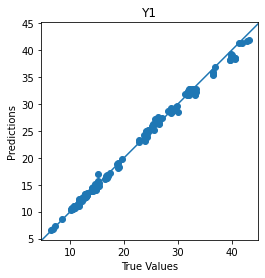

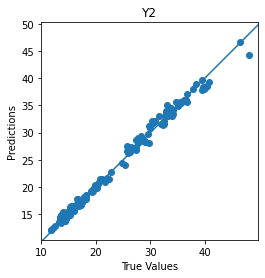

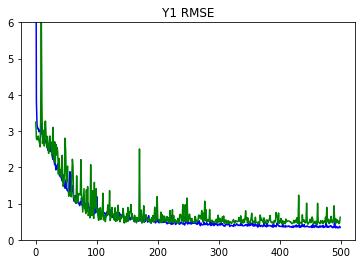

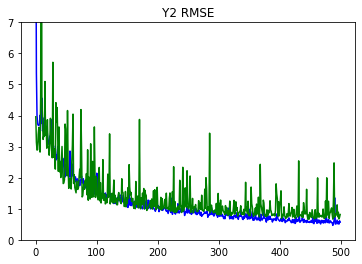

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)